# Including teleconnection indices as predictors

In this tutorial, we demonstrate how to set the atmospheric circulation indices included in the pyESD package as predictor for developing downscaling model. Specifically, in this notebook, we rely on the *Recursive* predictor selection method for the predictor selection and used *LassoLarsCV* as the learning model to evaluate the performance of the models generated with and without the indices. 

In [7]:
# import all the models required
import os 
import sys 
import pandas as pd 
import numpy as np 
from collections import OrderedDict
import socket

# modules related to pyESD

from pyESD.Weatherstation import read_station_csv
from pyESD.standardizer import MonthlyStandardizer
from pyESD.ESD_utils import store_pickle, store_csv
from pyESD.splitter import KFold
from pyESD.ESD_utils import Dataset
from pyESD.Weatherstation import read_weatherstationnames

### Data repositories
To avoid the repetition of the paths to the predictors and predictand datasets, we have included them in a script that can easily be imported in all the notebooks
1. The ERA5 datasets loaded with the Dataset module implemented in the ```pyESD.ESD_utils```
2. The constructed time series of the predictors are stored in a pickle file to avoid loading them again on the next run. We set the predictordir to store the datasets
3. We use the ```read_weatherstationnames``` to generated a list of all the weather station names that would be used to create the weather station objects
4. We import all these variable as ```from read_data import * ``` which is this file: [read_data.py](./read_data.py)

All the weather stations are stored in [data](./data)

### Predictors setting 

1. list of predictors to be loaded. Note that these names are the variables names stored in the netCDF files containing the predictors datasets
2. set the date range that would be used to selected the predictors. Here it should be the same as the training and validation period

In [8]:
# define the predictors that includes the teleconnection indices 

predictors_with_indices = ["NAO", "EA", "SCAN", "EAWR", "t2m", "tp","msl", "v10", "u10", 
              "u250", "u850", "u500","u700", "u1000","v250", "v850", "v500","v700", "v1000",
              "r250", "r850", "r500","r700", "r1000", "z250", "z500", "z700", "z850", "z1000", 
              "t250", "t850", "t500","t700", "t1000","dtd250", "dtd850", "dtd500","dtd700", "dtd1000"
              ]


In [9]:
# define the predictors without teleconnection indices
predictors_without = ["t2m", "tp","msl", "v10", "u10", 
              "u250", "u850", "u500","u700", "u1000","v250", "v850", "v500","v700", "v1000",
              "r250", "r850", "r500","r700", "r1000", "z250", "z500", "z700", "z850", "z1000", 
              "t250", "t850", "t500","t700", "t1000","dtd250", "dtd850", "dtd500","dtd700", "dtd1000"
              ]

In [10]:
# date-range for model training and validation
from1958to2010 = pd.date_range(start="1958-01-01", end="2010-12-31", freq="MS")

### control function

Define the control function that performs the predictor selection and model training.
1. read the station data as object that would apply all the ESD routines
2. set predictors with the list of predictors defined and the radius to construct the regional means
3. standardize the data with any of the standardizers. Here we use the MonthlyStandardizer method
4. defined the scoring metrics to be used for the validation
5. set the model to be used for the ESD training (here we will use the LassoLarsCV model)
6. fit the model, here we have to define the predictor selector method (here: Recursive ) to be used for selecting the predictors
7. get the selected predictors 
8. use the cross_validate_predict to get the cross-validation metrics of the model training 
9. store the selected predictors 
10. stored the validation metrics

In [33]:
def run_predictor_selection_example_to_test_indices(variable, cachedir, stationnames,
                    station_datadir, predictors, predictordir, radius):
    """
    Run an experiment using pyESD to perform predictor selection for a given variable.

    Args:
        variable (str): The target variable to predict, here Precipitation.
        regressor (str): The regression method to use, here we use the RidgeCV regression to test all the predictor selection
        methods.
        selector_method (str): The method for selecting predictors ("Recursive", "TreeBased", "Sequential").
        cachedir (str): Directory to store cached results, here all the files would be stored in the .
        stationnames (list): List of station names. it would be loaded from the read_data file
        station_datadir (str): Directory containing station data files: this is also set in the read the data file
        predictors (list): List of predictor variables.
        predictordir (str): Directory containing predictor data files.
        radius (float): Radius for selecting predictors: also defined in the read_data file
    """
    num_of_stations = len(stationnames)

    # Loop through all stations
    for i in range(num_of_stations):
        stationname = stationnames[i]
        
        # set the exact path for the station  data
        station_dir = os.path.join(station_datadir, stationname + ".csv")
        
        # 1. create the station object using the read_station_csv and apply all the methods on the station object
        
        SO_instance = read_station_csv(filename=station_dir, varname=variable)

        # 2. Setting predictors (generate the predictors using the defined predictor names)
        SO_instance.set_predictors(variable, predictors, predictordir, radius)

        # 3. Setting standardizer
        SO_instance.set_standardizer(variable, standardizer=MonthlyStandardizer(detrending=False, scaling=False))
        
        # perform correlation
        corr = SO_instance.predictor_correlation(variable, from1958to2010, ERA5Data, fit_predictors=True,
                                         fit_predictand=True, method="pearson", use_scipy=True)
        
        # 4. define the scoring metrics
        scoring = ["neg_root_mean_squared_error", "r2", "neg_mean_absolute_error"]
        
        # 5. Setting model with cross-validation
        SO_instance.set_model(variable, method="LassoLarsCV", scoring=scoring,
                              cv=KFold(n_splits=10))

        # 6. Fitting model with predictor selector option
        SO_instance.fit(variable, from1958to2010, ERA5Data, fit_predictors=True, predictor_selector=True,
                            selector_method="Recursive", selector_regressor="ARD",
                            cal_relative_importance=False)
        
        # 7. Extracting selected predictors
        selected_predictors = SO_instance.selected_names(variable)

        # 8. Training estimate for the same model
        
        score, ypred = SO_instance.cross_validate_and_predict(variable, from1958to2010, ERA5Data)

        # 9-10. Storing results using pickle
        store_pickle(stationname, "selected_predictors_" + "Recursive", selected_predictors, cachedir)
        store_pickle(stationname, "validation_score_" + "Recursive", score, cachedir)
        store_csv(stationname, "corrwith_predictors_scipy", corr, cachedir)

In [34]:
from read_data import radius, station_prec_datadir, stationnames_prec, ERA5Data, predictordir, cachedir_prec

### Experiment with the indices defined 
Perform the modelling with indices predictors (then store the data in a folder for the analysis)

In [36]:
run_predictor_selection_example_to_test_indices(variable="Precipitation",
                                    cachedir=cachedir_prec, stationnames=stationnames_prec,
                                    station_datadir=station_prec_datadir, predictors=predictors_with_indices, 
                                    predictordir=predictordir, radius=radius)

Freiburg 48.0232 7.8343 236.0
13 : optimal number of predictors and selected variables are Index(['NAO', 'SCAN', 't2m', 'tp', 'v10', 'u10', 'u850', 'v1000', 'r1000',
       't500', 'dtd250', 'dtd700', 'dtd1000'],
      dtype='object')
Konstanz 47.6952 9.1307 428.0
11 : optimal number of predictors and selected variables are Index(['SCAN', 'EAWR', 't2m', 'tp', 'u10', 'u250', 'u1000', 'v850', 'v700',
       'r700', 'dtd700'],
      dtype='object')
Mannheim 49.5063 8.5584 98.0
7 : optimal number of predictors and selected variables are Index(['NAO', 'EA', 'SCAN', 't2m', 'tp', 'u250', 't700'], dtype='object')
Nürnberg 49.503 11.0549 314.0
39 : optimal number of predictors and selected variables are Index(['NAO', 'EA', 'SCAN', 'EAWR', 't2m', 'tp', 'msl', 'v10', 'u10', 'u250',
       'u850', 'u500', 'u700', 'u1000', 'v250', 'v850', 'v500', 'v700',
       'v1000', 'r250', 'r850', 'r500', 'r700', 'r1000', 'z250', 'z500',
       'z700', 'z850', 'z1000', 't250', 't850', 't500', 't700', 't1000',


### Experiment without the indices 
Perform the modelling with predictors without indices (then store the data in a folder for the analysis)

In [24]:
run_predictor_selection_example_to_test_indices(variable="Precipitation",
                                    cachedir=cachedir_prec, stationnames=stationnames_prec,
                                    station_datadir=station_prec_datadir, predictors=predictors_without, 
                                    predictordir=predictordir, radius=radius)

Freiburg 48.0232 7.8343 236.0
29 : optimal number of predictors and selected variables are Index(['t2m', 'tp', 'v10', 'u10', 'u250', 'u850', 'u500', 'u700', 'u1000',
       'v250', 'v850', 'v500', 'v700', 'v1000', 'r250', 'r850', 'r500', 'r700',
       'r1000', 'z1000', 't250', 't850', 't500', 't1000', 'dtd250', 'dtd850',
       'dtd500', 'dtd700', 'dtd1000'],
      dtype='object')
Konstanz 47.6952 9.1307 428.0
35 : optimal number of predictors and selected variables are Index(['t2m', 'tp', 'msl', 'v10', 'u10', 'u250', 'u850', 'u500', 'u700',
       'u1000', 'v250', 'v850', 'v500', 'v700', 'v1000', 'r250', 'r850',
       'r500', 'r700', 'r1000', 'z250', 'z500', 'z700', 'z850', 'z1000',
       't250', 't850', 't500', 't700', 't1000', 'dtd250', 'dtd850', 'dtd500',
       'dtd700', 'dtd1000'],
      dtype='object')
Mannheim 49.5063 8.5584 98.0
6 : optimal number of predictors and selected variables are Index(['t2m', 'tp', 'u500', 'v250', 't500', 't700'], dtype='object')
Nürnberg 49.503 11

In [25]:
path_to_results_exp1 = "C:/Users/dboateng/Desktop/Python_scripts/ESD_Package/examples/tutorials/predictor_selection_with_indices/"
path_to_results_exp2 = "C:/Users/dboateng/Desktop/Python_scripts/ESD_Package/examples/tutorials/predictor_selection_without_indices/"

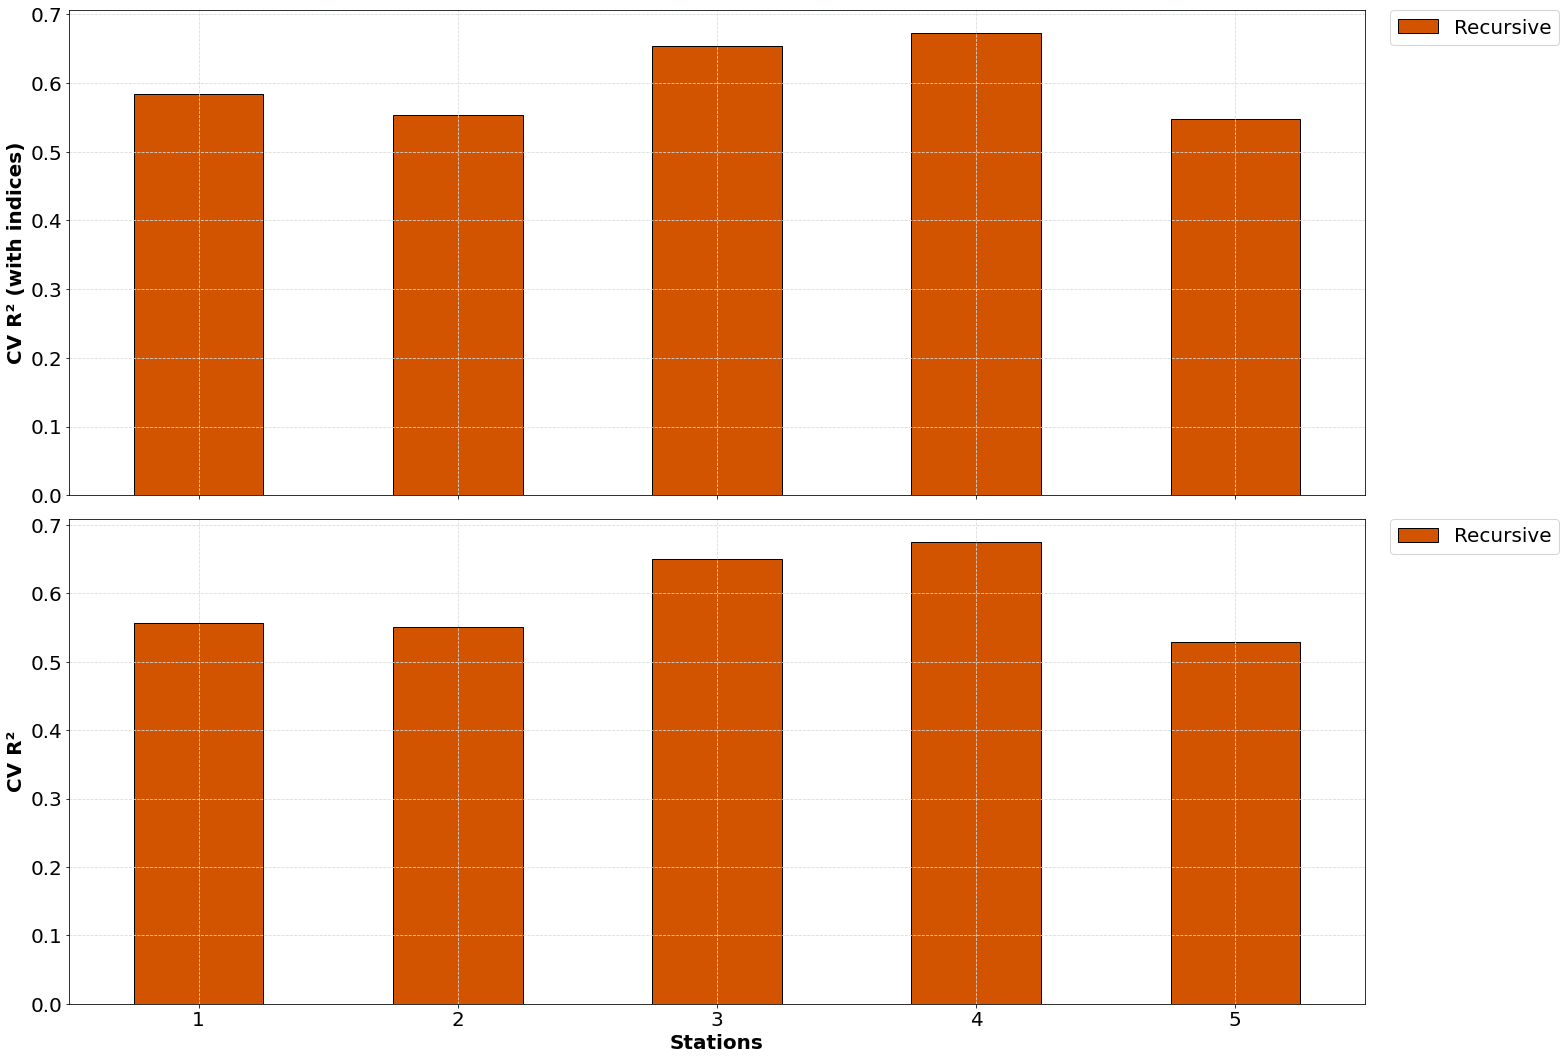

In [32]:
from pyESD.plot import barplot
import matplotlib.pyplot as plt 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15), sharey=False, sharex=True)

barplot(methods=["Recursive"], stationnames=stationnames_prec , path_to_data=path_to_results_exp1, 
        xlabel="Stations", ylabel="CV R² (with indices)", varname= "test_r2", varname_std ="test_r2_std",
        filename="validation_score_", legend=True, ax=ax1,)

barplot(methods=["Recursive"], stationnames=stationnames_prec , path_to_data=path_to_results_exp2, 
        xlabel="Stations", ylabel="CV R²", varname= "test_r2", varname_std ="test_r2_std",
        filename="validation_score_", legend=True, ax=ax2)

The models with indices estimate slight increase in performance in comparison to the models without indices